### Full mode code in one block

100%|█| 30/30 [00:32<00:00,  1.10s/trial, best loss: 0.008525601588189
Best hyperparameters found:  {'batch_size': 2, 'epochs': 2, 'n_layers': 1, 'n_units_layer_0': 2, 'n_units_layer_1': 2}
Epoch 1/2
57/57 [==============================] - 0s 1ms/step - loss: 0.9036 - accuracy: 0.4867 - val_loss: 0.8586 - val_accuracy: 0.6552
Epoch 2/2
2/2 [==============================] - 0s 1ms/step - loss: 0.8377 - accuracy: 0.5000
Test Accuracy: 50.00%


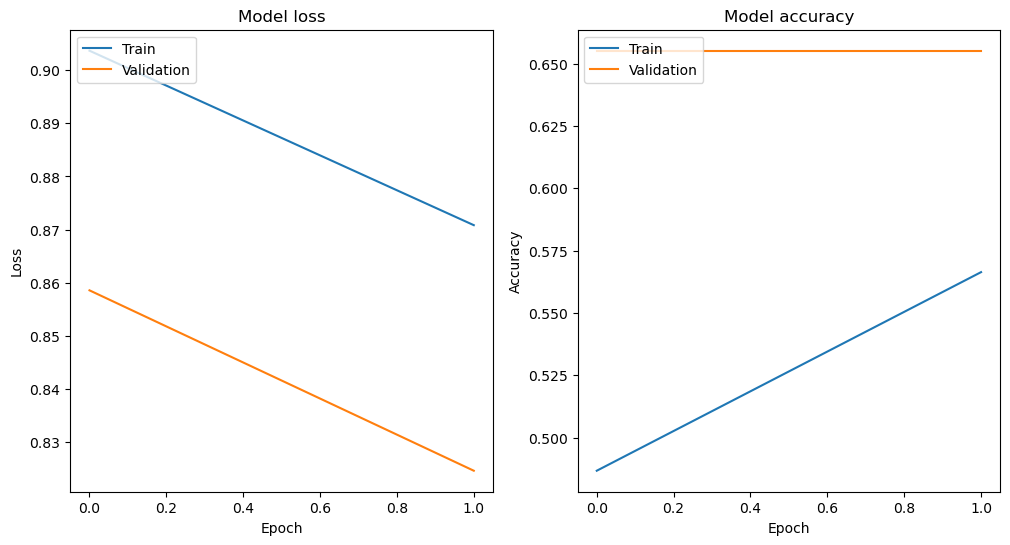

In [3]:
# Import Libraries
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from hyperopt import fmin, tpe, hp
import numpy as np
import matplotlib.pyplot as plt

# Load Data
data = load_wine()
X = data.data
y = data.target

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def build_model(params, input_shape):
    model = Sequential()
    model.add(Dense(params['n_units_layer_0'], activation='relu', input_shape=input_shape))
    if 'n_units_layer_1' in params:  # Check if the key exists before adding the layer
        model.add(Dense(params['n_units_layer_1'], activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter Space
space = {
    'n_units_layer_0': hp.choice('n_units_layer_0', [32, 64, 128]),
    'n_layers': hp.choice('n_layers', [1, 2]),
    'n_units_layer_1': hp.choice('n_units_layer_1', [32, 64, 128]), # Added as a separate option
    'epochs': hp.choice('epochs', [50, 100, 150]),
    'batch_size': hp.choice('batch_size', [32, 64, 128]),
}

# Objective Function
def objective(params):
    if params['n_layers'] == 1:
        params.pop('n_units_layer_1') # Remove if n_layers == 1
        
    model = build_model(params, input_shape=(X_train_scaled.shape[1],))
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=params['epochs'], batch_size=params['batch_size'], callbacks=[early_stop], verbose=0)
    loss = history.history['val_loss'][-1]
    return loss

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, verbose=2)
print("Best hyperparameters found: ", best)

# Train with Best Hyperparameters
best_params = {
    'n_units_layer_0': int(best['n_units_layer_0']),
    'n_layers': int(best['n_layers']),
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size']),
}
if best_params['n_layers'] == 2:
    best_params['n_units_layer_1'] = int(best['n_units_layer_1'])

model = build_model(best_params, input_shape=(X_train_scaled.shape[1],))
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=best_params['epochs'], batch_size=best_params['batch_size'], callbacks=[early_stop], verbose=1)

# Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Visualize Results
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
